In [2]:
%pylab inline
import numpy as np

import lasagne
from lasagne.init import Orthogonal
import theano
import theano.tensor as T

from math import *
import pickle

import time

import os
import sys

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log1p', 'isfinite', 'isclose', 'trunc', 'copysign', 'hypot', 'nan', 'sinh', 'isnan', 'cosh', 'sqrt', 'pi', 'ceil', 'cos', 'tanh', 'fmod', 'log', 'e', 'inf', 'fabs', 'ldexp', 'log2', 'sin', 'isinf', 'radians', 'degrees', 'gamma', 'frexp', 'expm1', 'log10', 'tan', 'exp', 'modf', 'floor']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [12]:
DIM = 2
SPARSE = 2
MINSEP = 0
MAXSEP = 2

class RepeatLayer(lasagne.layers.Layer):
    def __init__(self, incoming, n, **kwargs):
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.n = n

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1], None)

    def get_output_for(self, input, **kwargs):
        return  T.tile(input.reshape((input.shape[0], input.shape[1], 1)), (1,1,self.n))

def getRandomParams():
    vec1 = np.zeros(DIM)
    idx = np.random.permutation(DIM)
    for i in range(SPARSE):
        vec1[idx[i]] = np.random.randn()

    vec1 = vec1/np.sqrt(np.sum(vec1**2)+1e-32)

    vec2 = np.random.randn()

    vec2 = vec2/np.sqrt(np.sum(vec2**2)+1e-32)

    sig1 = np.random.randn(DIM,DIM)/sqrt(DIM)
    sig2 = np.random.randn(DIM,DIM)/sqrt(DIM)
    mean = MINSEP+(MAXSEP-MINSEP)*np.random.rand()
    return vec1,vec2,sig1,sig2,mean

def mkData(N, Nt):
    vec1,vec2,sig1,sig2,mean = getRandomParams()
    
    data = []
    tdata = []
    tlabels = []
    
    for i in range(N):
        s = np.random.randn(DIM)
        lbl = np.random.randint(2)
        example = np.matmul(s,(lbl==0)*sig1+(lbl==1)*sig2) + mean*(2*lbl-1)*vec1 + vec2
        example = np.hstack([example,np.array([2*lbl-1])])
        data.append(example)

    for i in range(Nt):
        s = np.random.randn(DIM)
        lbl = np.random.randint(2)
        example = np.matmul(s,(lbl==0)*sig1+(lbl==1)*sig2) + mean*(2*lbl-1)*vec1 + vec2
        example = np.hstack([example,np.array([0])])
        tdata.append(example)
        tlabels.append(lbl)
    
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)
    
    return data,tdata,tlabels

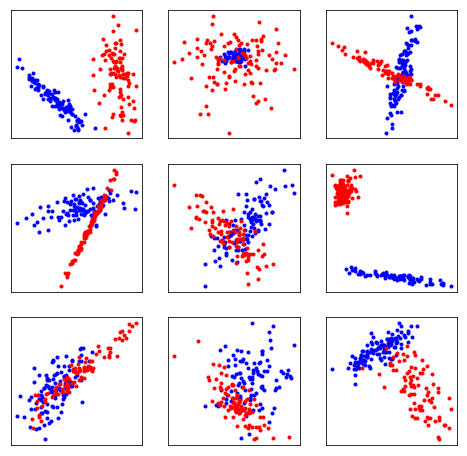

In [10]:
# Examples (2d)

for i in range(9):
    plt.subplot(3,3,i+1)
    train,test,labels = mkData(200,200)

    l0 = labels==0
    l1 = labels==1

    plt.plot(test[l0,0],test[l0,1],'b.')
    plt.plot(test[l1,0],test[l1,1],'r.')
    plt.xticks([])
    plt.yticks([])
plt.gcf().set_size_inches((8,8))
plt.show()

In [16]:
invar = T.tensor3()
invar2 = T.tensor3()
targ = T.matrix()

train_input = lasagne.layers.InputLayer((None,None,DIM+1), input_var = invar)

inp_shape = invar.shape[1]
test_shape = invar2.shape[1]

test_input = lasagne.layers.InputLayer((None,None,DIM+1), input_var = invar2)

train_shuf = lasagne.layers.DimshuffleLayer(train_input,(0,2,1))
test_shuf = lasagne.layers.DimshuffleLayer(test_input,(0,2,1))

# This block computes the population mean of some function of the input and concatenates that
# to the individual values.
def mkBlock(inp):
    nin1 = lasagne.layers.NINLayer(inp, num_units = 64)
    nin2 = lasagne.layers.NINLayer(nin1, num_units = 64)
    pool = lasagne.layers.GlobalPoolLayer(nin2)
    res = lasagne.layers.ReshapeLayer(pool, (-1,64,1))
    rep = RepeatLayer(res, n=inp_shape)
    return lasagne.layers.ConcatLayer([inp,rep])

cur = train_shuf
for i in range(3):
    cur = mkBlock(cur)

# This final pooling layer gives the learned embedding of the task inferred from the dataset
nin_final = lasagne.layers.NINLayer(cur, num_units = 256)
embedding = lasagne.layers.GlobalPoolLayer(nin_final)

# Make a copy for each test sample and concatenate...
emb_reshape = lasagne.layers.ReshapeLayer(embedding, (-1,256,1))
emb_repeat = RepeatLayer(emb_reshape,n=test_shape)

test_stack = lasagne.layers.ConcatLayer([test_shuf, emb_repeat],axis=1)

# Now process each example forwards
classify1 = lasagne.layers.NINLayer(test_stack, num_units = 256)
classify2 = lasagne.layers.NINLayer(classify1, num_units = 256)
classify3 = lasagne.layers.NINLayer(classify2, num_units = 256)
# Use skip connections for better gradient propagation
classify4 = lasagne.layers.NINLayer(lasagne.layers.ConcatLayer([classify1,classify3]), num_units = 256)

final = lasagne.layers.NINLayer(classify4, num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid)
output = lasagne.layers.DimshuffleLayer(final,(0,2,1))

out, embedding = lasagne.layers.get_output([output,embedding])
params = lasagne.layers.get_all_params(output,trainable=True)

# To avoid NaNs when the network receives an easy problem
out = T.clip(out[:,:,0],1e-5,1-1e-5)
elemloss = T.mean((-targ*T.log(out) - (1-targ)*T.log(1-out) ),axis=1)
loss = T.mean(elemloss)

updates = lasagne.updates.adam(loss, params, learning_rate = 1e-3)

train = theano.function([invar, invar2, targ], loss, updates=updates, allow_input_downcast=True)
process = theano.function([invar, invar2], [out,embedding], allow_input_downcast = True)
test = theano.function([invar, invar2, targ], loss,  allow_input_downcast=True)

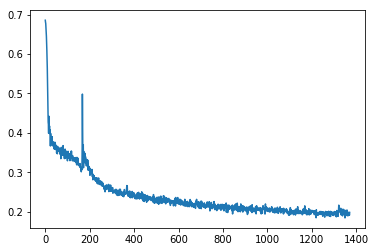

KeyboardInterrupt: 

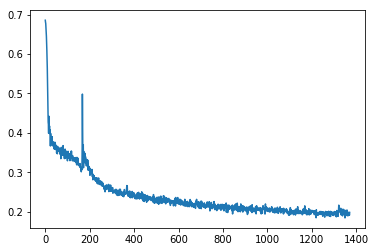

In [19]:
from IPython import display
import time

errs = []

# Train the classifier network
for epoch in range(1500):
    NT = 40
    N = 40
    data = []
    tdata = []
    tlabels = []
    for i in range(1600):
        d,td,l = mkData(N,NT)
        data.append(d)
        tdata.append(td)
        tlabels.append(l)
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)

    e0 = train(data,tdata,tlabels)
    errs.append(e0)
    
    if epoch%10 == 0:
        plt.clf()
        plt.plot(errs)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.01)

In [45]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

err = 0
for i in range(1600):
    d,td,l = mkData(N,NT)
    
    data = d[:,0:DIM]
    labels = d[:,DIM]
    
    svc = SVC(C=0.5,probability = True)
    svc.fit(data,labels)
    preds = np.clip(svc.predict_proba(td[:,0:DIM]),1e-5,1-1e-5)
    
    err += np.mean(-l*np.log(preds[:,1])-(1-l)*np.log(preds[:,0]))/1600.0
    
print(err)

lerr = 0
for i in range(1600):
    d,td,l = mkData(N,NT)
    
    data = d[:,0:DIM]
    labels = d[:,DIM]
    
    svc = LogisticRegression(penalty='l2',C=50)
    svc.fit(data,labels)
    preds = np.clip(svc.predict_proba(td[:,0:DIM]),1e-5,1-1e-5)
    
    lerr += np.mean(-l*np.log(preds[:,1])-(1-l)*np.log(preds[:,0]))/1600.0
    
print(lerr)

0.290264699218
0.316139911628


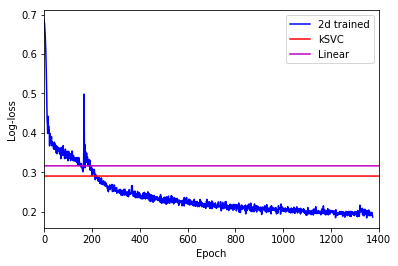

In [46]:
plt.plot(errs,'b-',label="2d trained")
plt.plot(np.arange(0,1500), err*np.ones(1500), 'r-', label="kSVC")
plt.plot(np.arange(0,1500), lerr*np.ones(1500), 'm-', label="Linear")
plt.xlim(0,1400)
plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.legend()
plt.show()

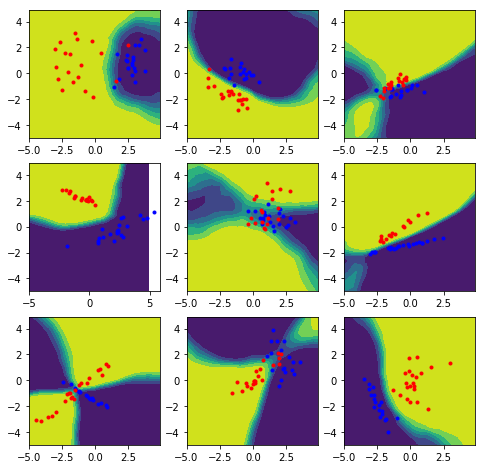

In [53]:
for i in range(9):
    plt.subplot(3,3,i+1)
    d,td,l = mkData(N,NT)

    xx,yy = np.meshgrid(np.arange(-5,5,0.1), np.arange(-5,5,0.1))
    testgrid = np.array([xx.ravel(),yy.ravel(),np.zeros(10000)]).T
    preds, embs = process(d.reshape(1,40,3),testgrid.reshape(1,10000,3))

    plt.contourf(xx,yy,preds.reshape((100,100)))
    plt.plot(d[d[:,2]==-1,0],d[d[:,2]==-1,1],'b.')
    plt.plot(d[d[:,2]==1,0],d[d[:,2]==1,1],'r.')
plt.gcf().set_size_inches((8,8))
plt.show()

In [75]:
# Higher-dimensional case
DIM = 64

train_input = lasagne.layers.InputLayer((None,None,DIM+1), input_var = invar)

inp_shape = invar.shape[1]
test_shape = invar2.shape[1]

test_input = lasagne.layers.InputLayer((None,None,DIM+1), input_var = invar2)

train_shuf = lasagne.layers.DimshuffleLayer(train_input,(0,2,1))
test_shuf = lasagne.layers.DimshuffleLayer(test_input,(0,2,1))

# This block computes the population mean of some function of the input and concatenates that
# to the individual values.
def mkBlock(inp):
    nin1 = lasagne.layers.NINLayer(inp, num_units = 64)
    nin2 = lasagne.layers.NINLayer(nin1, num_units = 64)
    pool = lasagne.layers.GlobalPoolLayer(nin2)
    res = lasagne.layers.ReshapeLayer(pool, (-1,64,1))
    rep = RepeatLayer(res, n=inp_shape)
    return lasagne.layers.ConcatLayer([inp,rep])

cur = train_shuf
for i in range(3):
    cur = mkBlock(cur)

# This final pooling layer gives the learned embedding of the task inferred from the dataset
nin_final = lasagne.layers.NINLayer(cur, num_units = 256)
embedding = lasagne.layers.GlobalPoolLayer(nin_final)

# Make a copy for each test sample and concatenate...
emb_reshape = lasagne.layers.ReshapeLayer(embedding, (-1,256,1))
emb_repeat = RepeatLayer(emb_reshape,n=test_shape)

test_stack = lasagne.layers.ConcatLayer([test_shuf, emb_repeat],axis=1)

# Now process each example forwards
classify1 = lasagne.layers.NINLayer(test_stack, num_units = 256)
classify2 = lasagne.layers.NINLayer(classify1, num_units = 256)
classify3 = lasagne.layers.NINLayer(classify2, num_units = 256)
# Use skip connections for better gradient propagation
classify4 = lasagne.layers.NINLayer(lasagne.layers.ConcatLayer([classify1,classify3]), num_units = 256)

final = lasagne.layers.NINLayer(classify4, num_units=1,nonlinearity=lasagne.nonlinearities.sigmoid)
output = lasagne.layers.DimshuffleLayer(final,(0,2,1))

out, embedding = lasagne.layers.get_output([output,embedding])
params = lasagne.layers.get_all_params(output,trainable=True)

# To avoid NaNs when the network receives an easy problem
out = T.clip(out[:,:,0],1e-5,1-1e-5)
elemloss = T.mean((-targ*T.log(out) - (1-targ)*T.log(1-out) ),axis=1)
loss = T.mean(elemloss)

updates = lasagne.updates.adam(loss, params, learning_rate = 1e-3)

train = theano.function([invar, invar2, targ], loss, updates=updates, allow_input_downcast=True)
process = theano.function([invar, invar2], [out,embedding], allow_input_downcast = True)
test = theano.function([invar, invar2, targ], loss,  allow_input_downcast=True)

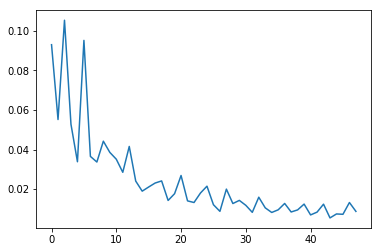

KeyboardInterrupt: 

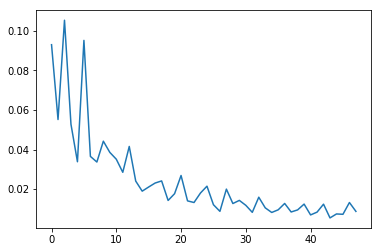

In [79]:
errs0 = []

# The actual problem we want to solve (6-sparse) is too hard to start with, 
# so we first pretrain on much easier problems and then make it progressively
# sparser

SPARSE = 24
MINSEP = 5
MAXSEP = 10

# Pretrain the classifier network
for epoch in range(500):
    NT = 40
    N = 40
    data = []
    tdata = []
    tlabels = []
    for i in range(100):
        d,td,l = mkData(N,NT)
        data.append(d)
        tdata.append(td)
        tlabels.append(l)
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)

    e0 = train(data,tdata,tlabels)
    errs0.append(e0)
    
    plt.clf()
    plt.plot(errs0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

SPARSE = 16
MINSEP = 2
MAXSEP = 6

for epoch in range(500):
    NT = 40
    N = 40
    data = []
    tdata = []
    tlabels = []
    for i in range(100):
        d,td,l = mkData(N,NT)
        data.append(d)
        tdata.append(td)
        tlabels.append(l)
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)

    e0 = train(data,tdata,tlabels)
    errs0.append(e0)
    
    plt.clf()
    plt.plot(errs0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    
SPARSE = 10
MINSEP = 1
MAXSEP = 4

for epoch in range(1000):
    NT = 40
    N = 40
    data = []
    tdata = []
    tlabels = []
    for i in range(100):
        d,td,l = mkData(N,NT)
        data.append(d)
        tdata.append(td)
        tlabels.append(l)
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)

    e0 = train(data,tdata,tlabels)
    errs0.append(e0)
    
    plt.clf()
    plt.plot(errs0)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

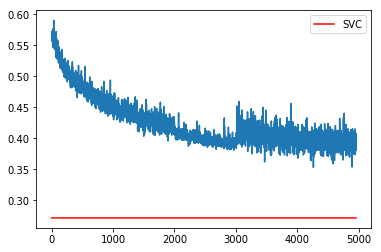

KeyboardInterrupt: 

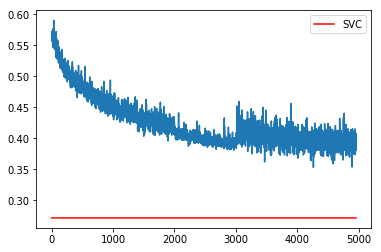

In [114]:
SPARSE = 6
MINSEP = 1
MAXSEP = 2

#errs1 = []

# Train the classifier network
for epoch in range(5000):
    NT = 40
    N = 40
    data = []
    tdata = []
    tlabels = []
    for i in range(200):
        d,td,l = mkData(N,NT)
        data.append(d)
        tdata.append(td)
        tlabels.append(l)
    data = np.array(data)
    tdata = np.array(tdata)
    tlabels = np.array(tlabels)

    e0 = train(data,tdata,tlabels)
    errs1.append(e0)
    
    plt.clf()
    plt.plot(errs1)
    L = len(errs1)
    plt.plot(np.arange(0,L),np.ones(L)*err,'r-',label="SVC")
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [91]:
err = 0
for i in range(1600):
    d,td,l = mkData(N,NT)
    
    data = d[:,0:DIM]
    labels = d[:,DIM]
    
    svc = SVC(C=5,probability = True)
    svc.fit(data,labels)
    preds = np.clip(svc.predict_proba(td[:,0:DIM]),1e-5,1-1e-5)
    
    err += np.mean(-l*np.log(preds[:,1])-(1-l)*np.log(preds[:,0]))/1600.0
    
print(err)

lerr = 0
for i in range(1600):
    d,td,l = mkData(N,NT)
    
    data = d[:,0:DIM]
    labels = d[:,DIM]
    
    svc = LogisticRegression(penalty='l1',C=50)
    svc.fit(data,labels)
    preds = np.clip(svc.predict_proba(td[:,0:DIM]),1e-5,1-1e-5)
    
    lerr += np.mean(-l*np.log(preds[:,1])-(1-l)*np.log(preds[:,0]))/1600.0
    
print(lerr)

0.271511943652
0.458407727986


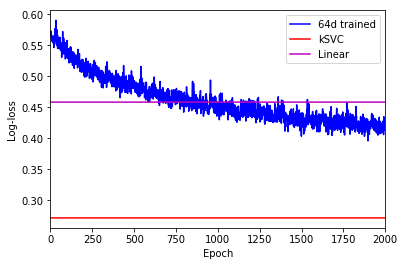

In [92]:
plt.plot(errs1,'b-',label="64d trained")
plt.plot(np.arange(0,2000), err*np.ones(2000), 'r-', label="kSVC")
plt.plot(np.arange(0,2000), lerr*np.ones(2000), 'm-', label="Linear")
plt.xlim(0,2000)
plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.legend()
plt.show()

In [96]:
data = []
tdata = []
tlabels = []
for i in range(400):
    d,td,l = mkData(N,NT)
    data.append(d)
    tdata.append(td)
    tlabels.append(l)
data = np.array(data)
tdata = np.array(tdata)
tlabels = np.array(tlabels)

preds, embs = process(data,tdata)

In [95]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [98]:
pca = PCA()
pembs = pca.fit_transform(embs)

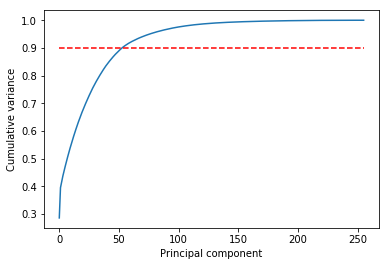

In [100]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(256),np.ones(256)*0.9,'r--')
plt.xlabel("Principal component")
plt.ylabel("Cumulative variance")
plt.show()

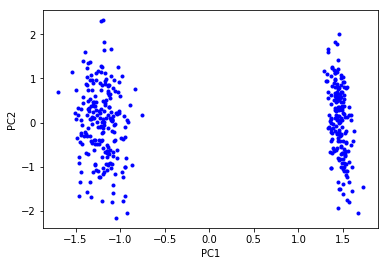

In [110]:
plt.plot(pembs[:,0], pembs[:,1],'b.')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [111]:
tsn = TSNE()
tembs = tsn.fit_transform(embs)

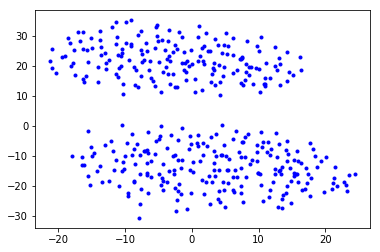

In [112]:
plt.plot(tembs[:,0],tembs[:,1],'b.')
plt.show()